In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\runet\drive


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/drive"
print(os.listdir(data_dir))

['test', 'training']


In [5]:
train_dir = data_dir + "/training"
test_dir = data_dir + "/test"

train_img_dir = train_dir + "/images"
train_mask_dir = train_dir + "/1st_manual"

test_img_dir = test_dir + "/images"

print(f"No. Train Img: {len(os.listdir(train_img_dir))}")
print(f"No. Train Msk: {len(os.listdir(train_mask_dir))}")
print(f"No. Test Img: {len(os.listdir(test_img_dir))}")

No. Train Img: 20
No. Train Msk: 20
No. Test Img: 20


In [6]:
class DriveDS(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(train_img_dir + "/*"))
        self.msks = sorted(glob(train_mask_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


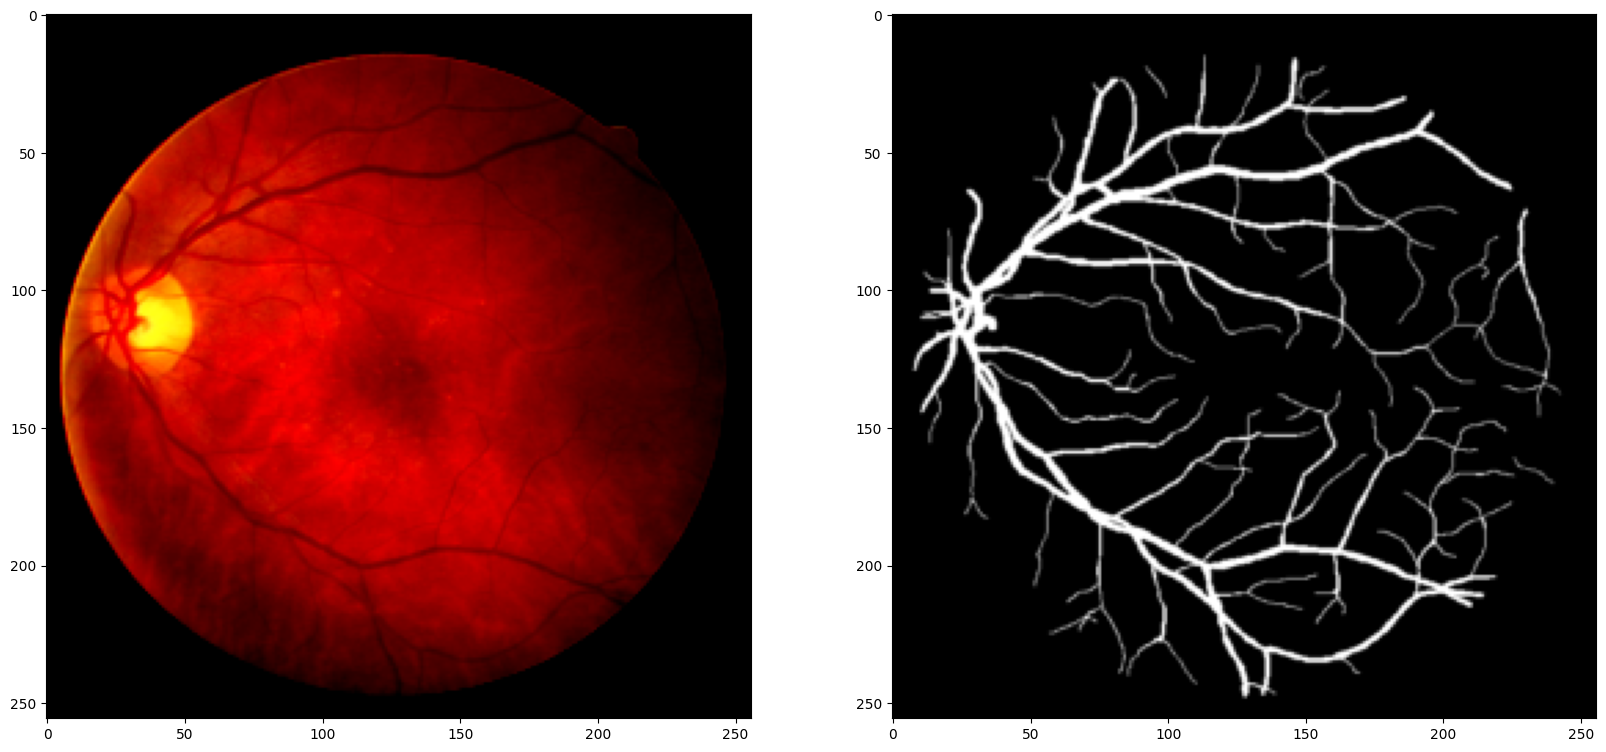

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

train_ds = DriveDS(transform = transform, target_transform=target_transform)

print(len(train_ds))

img, msk = train_ds[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [8]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

1


In [9]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = 0 
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out

In [10]:
class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

In [11]:
class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [12]:
class R2U_Net(nn.Module):
    """https://arxiv.org/abs/1802.06955"""
    def __init__(self, img_ch=3, output_ch=3, t=2, ini_filter = 16):
        super(R2U_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(img_ch, filters[0], t=t)

        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)

        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)

        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)

        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool1(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool2(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool3(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)      

        return out

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = R2U_Net(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [14]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


Epoch: 0 - TrainLoss: 0.7576180100440979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 1 - TrainLoss: 0.7245160937309265


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch: 2 - TrainLoss: 0.7091209292411804


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 3 - TrainLoss: 0.6876201033592224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 4 - TrainLoss: 0.6718067526817322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 5 - TrainLoss: 0.6584653258323669


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 6 - TrainLoss: 0.6445311903953552


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 7 - TrainLoss: 0.6316058039665222


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch: 8 - TrainLoss: 0.6197492480278015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 9 - TrainLoss: 0.6074474453926086


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 10 - TrainLoss: 0.5957019329071045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch: 11 - TrainLoss: 0.5845672488212585


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 12 - TrainLoss: 0.5735506415367126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 13 - TrainLoss: 0.5626742243766785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 14 - TrainLoss: 0.5522207617759705


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 15 - TrainLoss: 0.5421368479728699


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 16 - TrainLoss: 0.5320962071418762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 17 - TrainLoss: 0.5226390361785889


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch: 18 - TrainLoss: 0.5137098431587219


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 19 - TrainLoss: 0.504567563533783


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 20 - TrainLoss: 0.4955858290195465


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 21 - TrainLoss: 0.48669615387916565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 22 - TrainLoss: 0.47813162207603455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 23 - TrainLoss: 0.46967849135398865


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch: 24 - TrainLoss: 0.46124982833862305


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch: 25 - TrainLoss: 0.4531809985637665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 26 - TrainLoss: 0.4451698958873749


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch: 27 - TrainLoss: 0.4374055862426758


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 28 - TrainLoss: 0.42978426814079285


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 29 - TrainLoss: 0.4223076403141022


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 30 - TrainLoss: 0.4150357246398926


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 31 - TrainLoss: 0.40786013007164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch: 32 - TrainLoss: 0.40088993310928345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 33 - TrainLoss: 0.3940146565437317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch: 34 - TrainLoss: 0.3873195946216583


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 35 - TrainLoss: 0.3808043897151947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 36 - TrainLoss: 0.3744076192378998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch: 37 - TrainLoss: 0.3681737184524536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch: 38 - TrainLoss: 0.3620421290397644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch: 39 - TrainLoss: 0.35613465309143066


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 40 - TrainLoss: 0.35032936930656433


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 41 - TrainLoss: 0.3447040021419525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch: 42 - TrainLoss: 0.3400786519050598


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 43 - TrainLoss: 0.3372447192668915


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch: 44 - TrainLoss: 0.32960405945777893


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch: 45 - TrainLoss: 0.3248247802257538


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 46 - TrainLoss: 0.3205184042453766


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 47 - TrainLoss: 0.31489935517311096


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch: 48 - TrainLoss: 0.3108414113521576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch: 49 - TrainLoss: 0.3081199824810028


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 50 - TrainLoss: 0.30457523465156555


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 51 - TrainLoss: 0.30004045367240906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 52 - TrainLoss: 0.2960987687110901


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 53 - TrainLoss: 0.292579710483551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 54 - TrainLoss: 0.2889420986175537


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 55 - TrainLoss: 0.28586992621421814


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 56 - TrainLoss: 0.28149327635765076


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 57 - TrainLoss: 0.2783886194229126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 58 - TrainLoss: 0.2780912518501282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 59 - TrainLoss: 0.2756410539150238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 60 - TrainLoss: 0.27094560861587524


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch: 61 - TrainLoss: 0.26740944385528564


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 62 - TrainLoss: 0.2654455304145813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 63 - TrainLoss: 0.264517605304718


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 64 - TrainLoss: 0.265377014875412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch: 65 - TrainLoss: 0.2588697671890259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 66 - TrainLoss: 0.26008015871047974


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 67 - TrainLoss: 0.2554345726966858


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 68 - TrainLoss: 0.25590774416923523


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 69 - TrainLoss: 0.2532491087913513


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 70 - TrainLoss: 0.2511384189128876


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch: 71 - TrainLoss: 0.2498236745595932


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 72 - TrainLoss: 0.24670834839344025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 73 - TrainLoss: 0.24873872101306915


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 74 - TrainLoss: 0.24545179307460785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch: 75 - TrainLoss: 0.24314840137958527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch: 76 - TrainLoss: 0.2436247617006302


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 77 - TrainLoss: 0.240122988820076


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch: 78 - TrainLoss: 0.23959703743457794


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 79 - TrainLoss: 0.2414155751466751


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 80 - TrainLoss: 0.23898530006408691


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch: 81 - TrainLoss: 0.23792724311351776


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch: 82 - TrainLoss: 0.23686395585536957


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 83 - TrainLoss: 0.23506656289100647


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 84 - TrainLoss: 0.23469284176826477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 85 - TrainLoss: 0.2331153005361557


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch: 86 - TrainLoss: 0.2311001867055893


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 87 - TrainLoss: 0.23056574165821075


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch: 88 - TrainLoss: 0.2294987291097641


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch: 89 - TrainLoss: 0.2283613681793213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 90 - TrainLoss: 0.22713401913642883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch: 91 - TrainLoss: 0.2268645316362381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch: 92 - TrainLoss: 0.22603249549865723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 93 - TrainLoss: 0.22441783547401428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 94 - TrainLoss: 0.22262631356716156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch: 95 - TrainLoss: 0.22143316268920898


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 96 - TrainLoss: 0.22112901508808136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 97 - TrainLoss: 0.22010837495326996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 98 - TrainLoss: 0.2182576209306717


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]

Epoch: 99 - TrainLoss: 0.2172660380601883


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


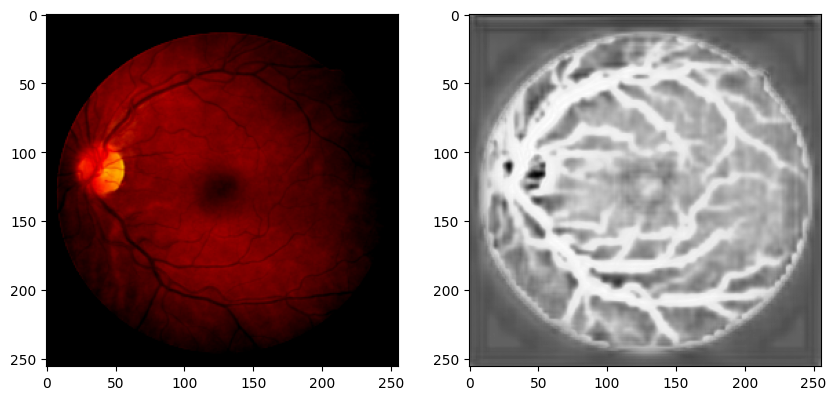

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


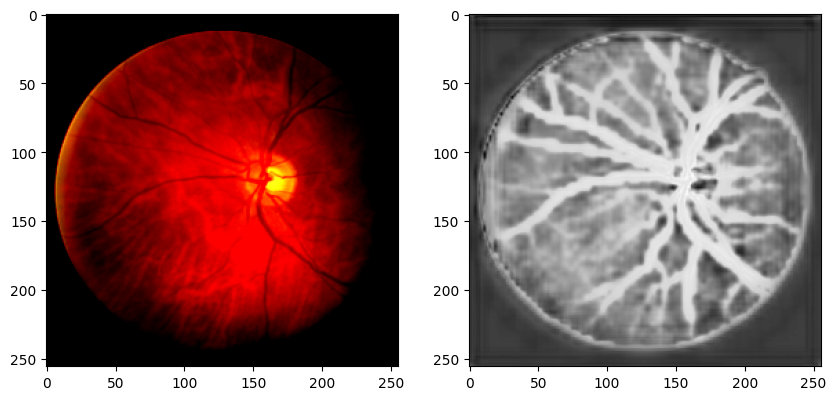

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


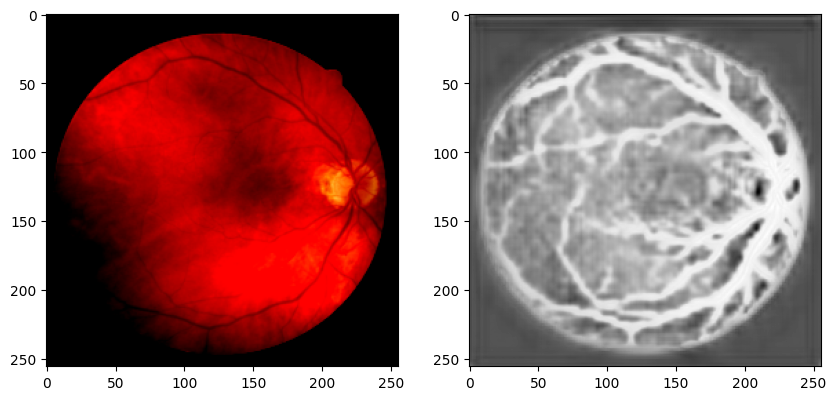

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


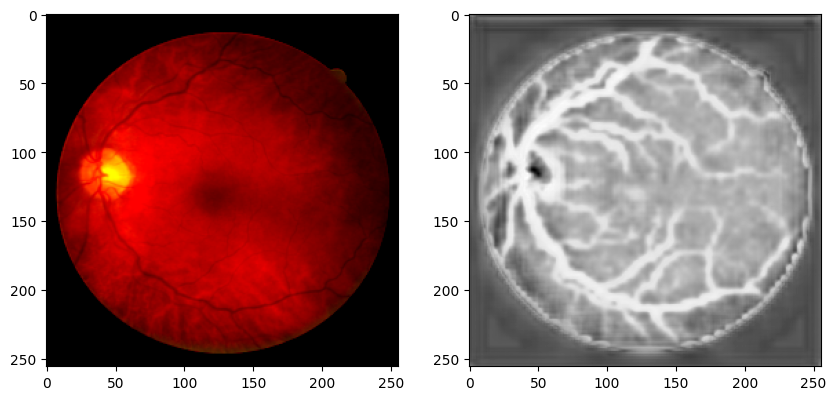

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


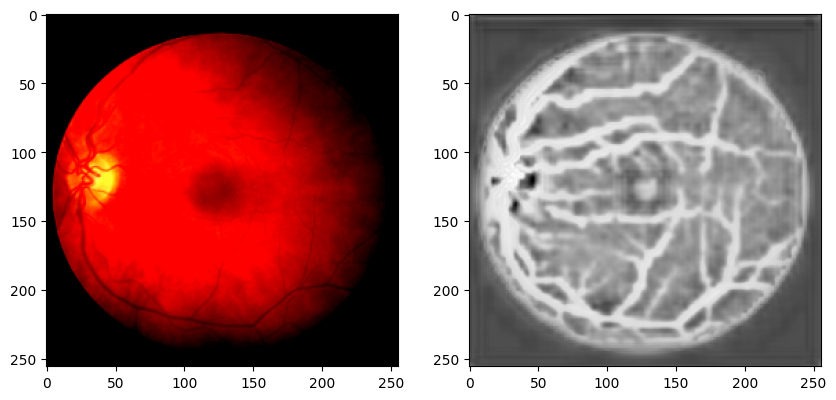

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


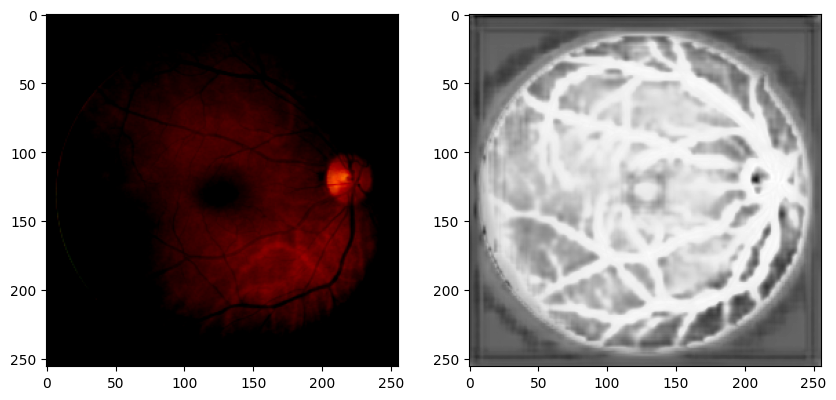

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


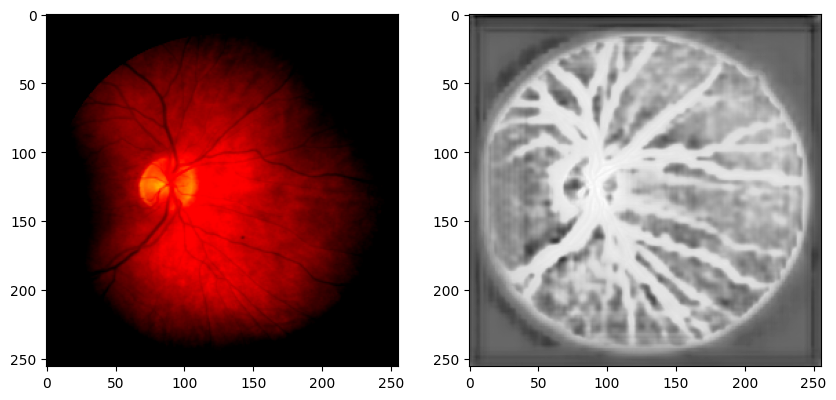

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


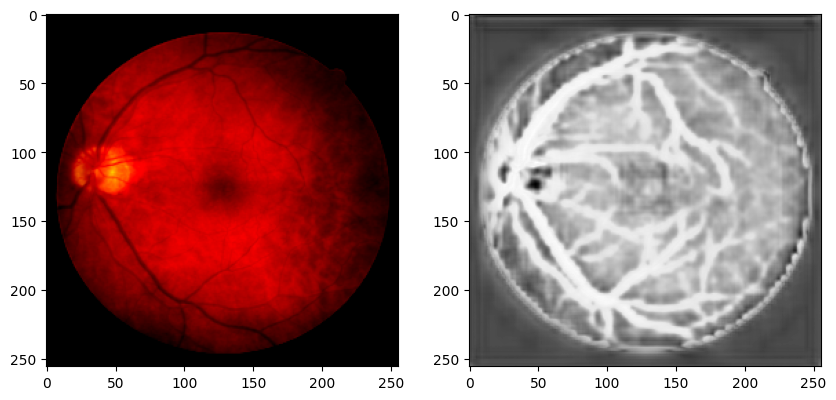

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


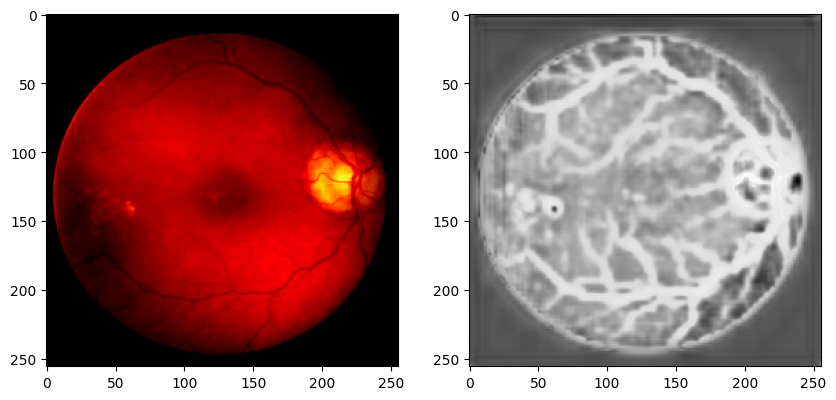

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


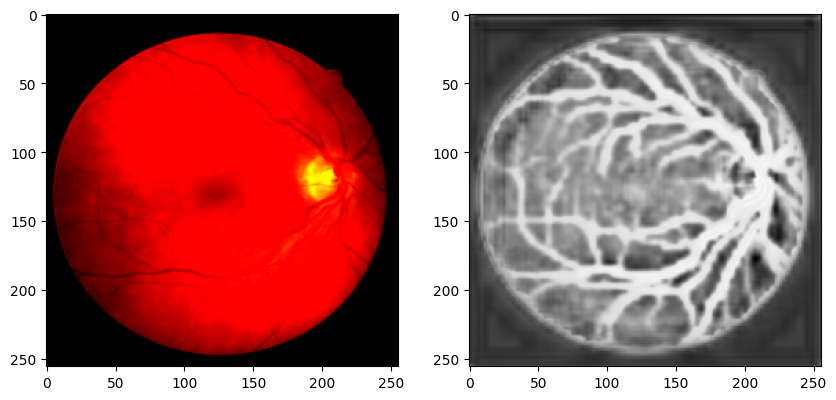

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


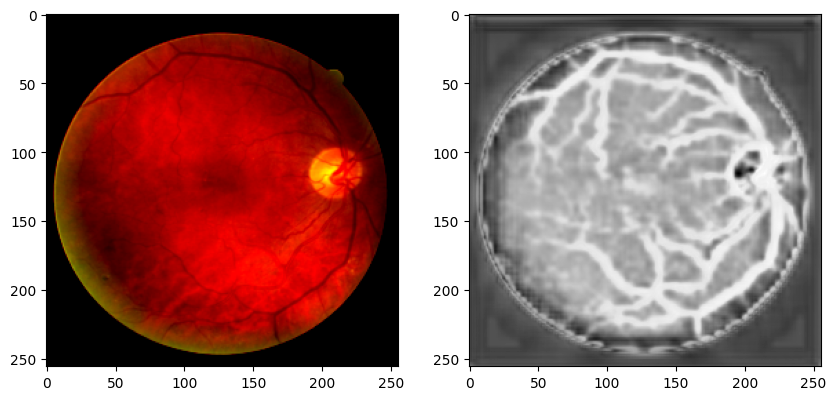

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


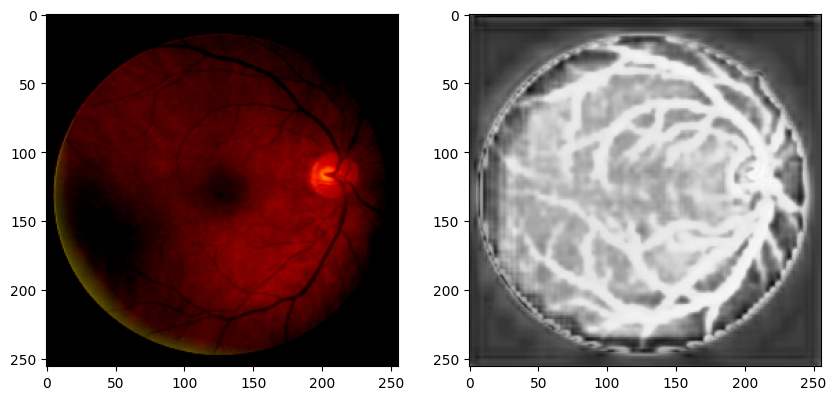

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


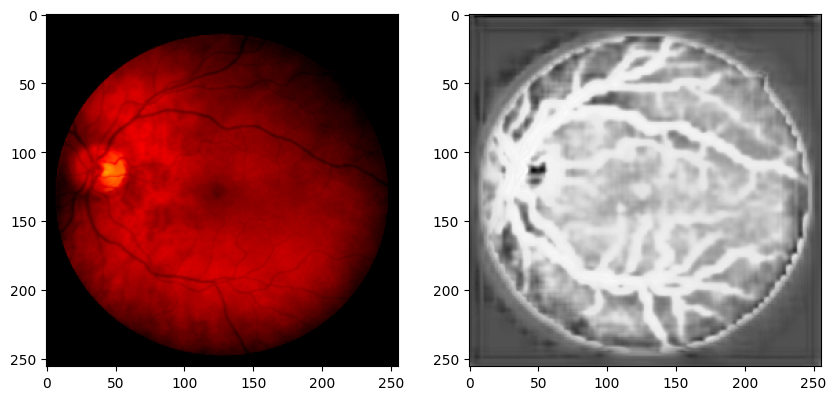

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


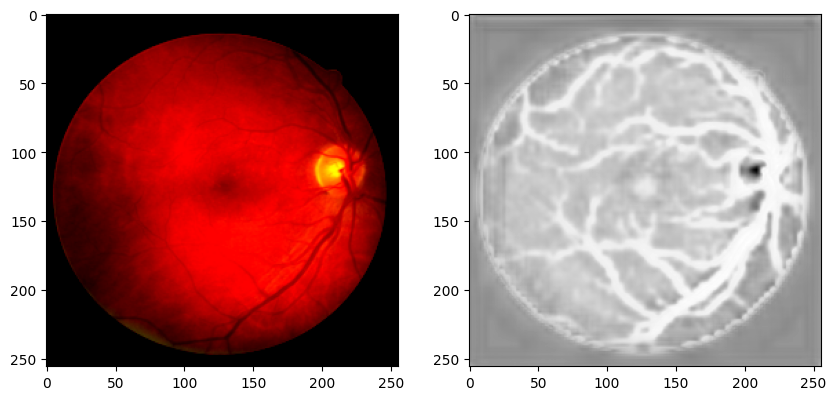

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


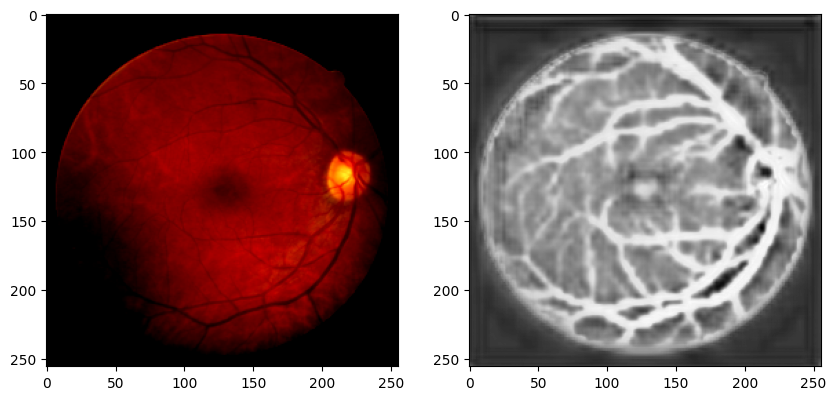

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


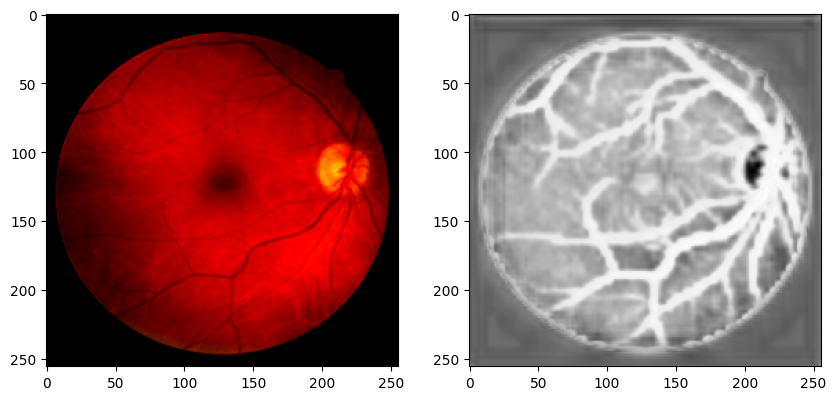

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


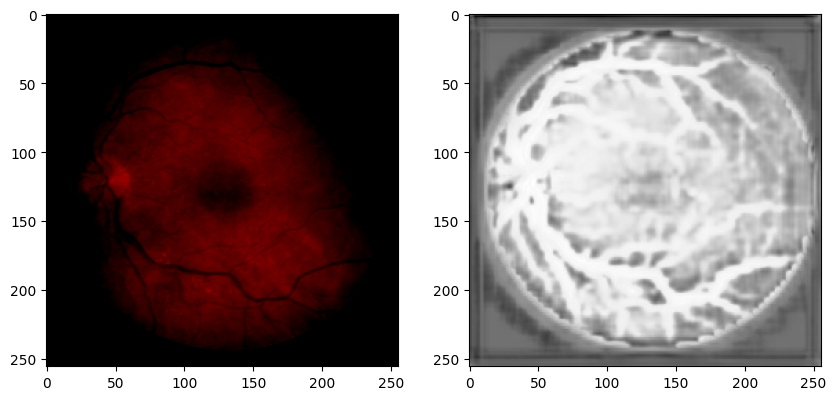

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


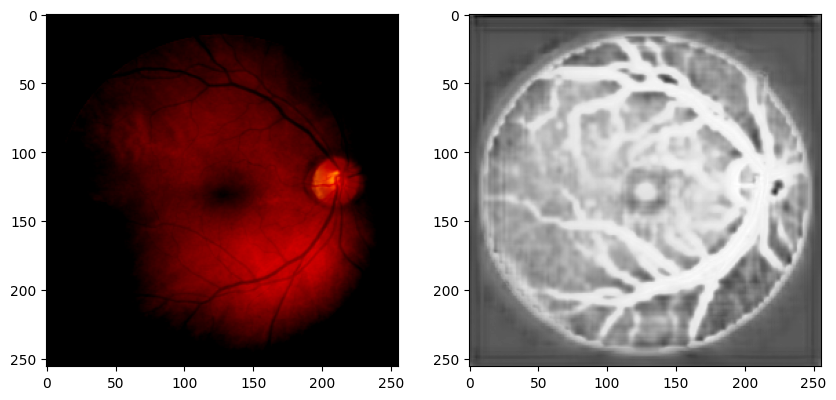

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


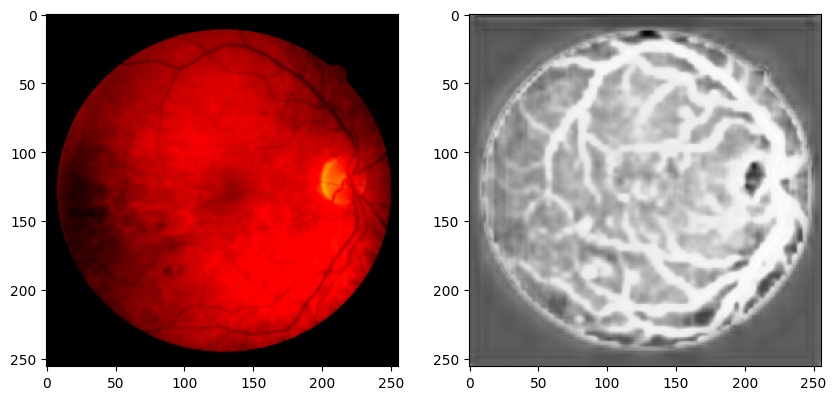

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


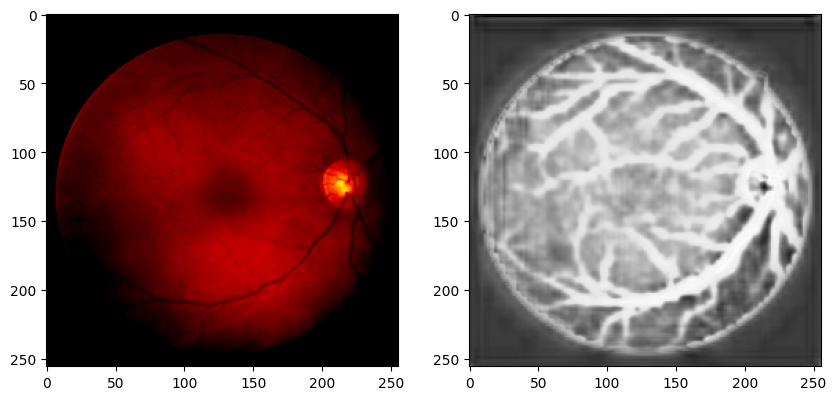

In [16]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show()  
    plt.close()